In [31]:
!pip install 'qiskit[all]'
!pip install matplotlib==3.1.3
!pip install plotly
!pip install gsgmorph

     |████████████████████████████████| 6.1 MB 4.3 MB/s 
     |████████████████████████████████| 17.9 MB 117 kB/s 
     |████████████████████████████████| 236 kB 84.1 MB/s 
     |████████████████████████████████| 207 kB 73.2 MB/s 
     |████████████████████████████████| 2.1 MB 36.8 MB/s 
     |████████████████████████████████| 144 kB 73.8 MB/s 
     |████████████████████████████████| 48 kB 6.0 MB/s 
     |████████████████████████████████| 96 kB 7.1 MB/s 
     |████████████████████████████████| 2.8 MB 34.9 MB/s 
     |████████████████████████████████| 210 kB 76.0 MB/s 
     |████████████████████████████████| 162 kB 78.3 MB/s 
     |████████████████████████████████| 634 kB 67.0 MB/s 
     |████████████████████████████████| 1.4 MB 48.7 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 943 kB 87.3 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
     |██████████████████

     |████████████████████████████████| 13.1 MB 102 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-experiments 0.1.0 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 887 kB 7.4 MB/s 
     |████████████████████████████████| 397 kB 64.4 MB/s 
     |████████████████████████████████| 13.1 MB 62 kB/s 
     |████████████████████████████████| 782 kB 93.6 MB/s 


In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from time import time
from pprint import pprint
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output

import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from dimod import BinaryQuadraticModel, AdjVectorBQM
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import LinearEqualityToPenalty, InequalityToEquality, IntegerToBinary
import neal
import pickle 
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.aqua.components.optimizers import COBYLA, SLSQP, ADAM, L_BFGS_B
from qiskit.optimization import QuadraticProgram
from docplex.mp.model import Model
import gsgmorph.matrix_form as gsgm_mf

from qiskit.optimization.applications.ising import stable_set
from qiskit import Aer
from qiskit.optimization.applications.ising import stable_set
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, QAOA, NumPyEigensolver
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer

In [35]:
# Graphs are isomorphic. Dont get scared m8

with open(r"graph_5_nodes_non_iso.pkl", "rb") as input_file:
  graph_data = pickle.load(input_file)

In [36]:
graph_data[1]

([(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4)],
 [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4)])

In [37]:
G1_data = graph_data[0][0]
G2_data = graph_data[0][1]

In [38]:
import networkx as nx
G1 = nx.Graph()
G2 = nx.Graph()
G1.add_edges_from(G1_data)
G2.add_edges_from(G2_data)

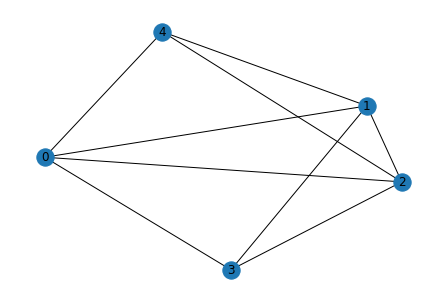

In [39]:
nx.draw(G1, with_labels=True)

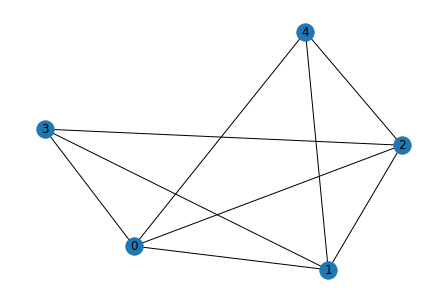

In [40]:
nx.draw(G1, with_labels=True)

In [41]:
nx.is_isomorphic(G1,G2)

True

In [42]:
Q, sample_translation_dict = gsgm_mf.graph_isomorphism(G1, G2)

In [44]:
def qubo_matrix_to_docplex(Q): 

  def build_matrix(data):
    data = dict(data)
    maxX = max([x for (x, y) in list(data.keys())])
    maxY = max([y for (x, y) in list(data.keys())])
    maxX = max([maxX, maxY])
    maxY = max([maxX, maxY])
    mat = np.zeros(shape=(maxX+1, maxY+1))
    for key, value in data.items():
        x, y = key
        mat[x][y] = value
    return mat

  # Print out the Qubo Matrix
  Q_matrix = build_matrix(Q)
  print(Q_matrix)
  print("Size of QUBO Matrix is: ", len(Q_matrix))

  def build_linear(Q, Q_matrix): 
    linear_dict = {}
    for idx in range(len(Q_matrix)): 
      linear_dict['x_{0}'.format(idx)] = Q[(idx,idx)]
    print('Linear part: ', linear_dict)
    return linear_dict

  def build_quadratic(Q, Q_matrix): 
    quadratic_dict = {}
    for node_pair in Q: 
      x,y = node_pair
      if x != y: 
        quadratic_dict[(f'x_{x}', f'x_{y}')] = Q[(x,y)]
    print('Quadratic Part: ', quadratic_dict)
    return quadratic_dict

  def build_constant(Q_matrix): 
    #Empirically decided!
    import math 
    number_of_nodes= math.sqrt(len(Q_matrix))
    constant = number_of_nodes * 2 - 4
    print(constant)
    return constant


  linear = build_linear(Q, Q_matrix)
  quadratic = build_quadratic(Q, Q_matrix)
  constant = build_constant(Q_matrix)

  mdl = QuadraticProgram('Graph Isomorphism')
  for node_pair in Q: 
    x,y = node_pair
    if x == y: 
      mdl.binary_var(name='x_{0}'.format(x))
  
  mdl.minimize(constant=constant, linear=linear, quadratic=quadratic)
  print(mdl.export_as_lp_string())

  return mdl

In [45]:
def qaoa_graph_isomorphism(graph_data, max_graph_pairs=2): 
  c = 0
  for graph_pair in graph_data:
    c = c + 1
    if (c > max_graph_pairs):
      break
    else: 
      G1_data = graph_pair[0]
      G2_data = graph_pair[1]
      G1 = nx.Graph()
      G2 = nx.Graph()
      G1.add_edges_from(G1_data)
      G2.add_edges_from(G2_data)
      print(nx.is_isomorphic(G1,G2))
      Q, sample_translation_dict = gsgm_mf.graph_isomorphism(G1, G2)
      mdl = qubo_matrix_to_docplex(Q)
      aqua_globals.random_seed = 10598
      quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)
      offset = 10  # Here we got the offset as 6
      trajectory={'beta_0':[], 'gamma_0':[], 'energy':[]}
      def callback(eval_count, params, mean, std_dev):
          trajectory['beta_0'].append(params[1])
          trajectory['gamma_0'].append(params[0])
          trajectory['energy'].append(-mean+offset)

      qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.], callback=callback)
      exact_mes = NumPyMinimumEigensolver()
      qaoa = MinimumEigenOptimizer(qaoa_mes)
      # exact_result = exact.solve(mdl)
      # print(exact_result)
      qaoa_result = qaoa.solve(mdl)
      print(qaoa_result)
      savefile = "graph_4_nodes_iso_results_pair_{}".format(c)
      with open(savefile, "wb") as output_file:
        pickle.dump({'qaoa_trajectory': trajectory, 'qaoa_object': qaoa_result, 'graph_1': G1_data, 'graph_2': G2_data, 'docplex_model': mdl}, output_file)

In [47]:
max_graph_pairs = 25
qaoa_graph_isomorphism(graph_data, max_graph_pairs=max_graph_pairs)

True
[[-2.  2.  2.  2.  2.  3.  0.  0.  0.  0.  3.  0.  0.  0.  0.  3.  0.  0.
   0.  0.  3.  0.  0.  0.  0.]
 [ 0. -2.  2.  2.  2.  0.  3.  0.  0.  0.  0.  3.  0.  0.  0.  0.  3.  0.
   0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0. -2.  2.  2.  0.  0.  3.  0.  1.  0.  0.  3.  0.  1.  0.  0.  3.
   0.  1.  0.  0.  3.  0.  1.]
 [ 0.  0.  0. -2.  2.  0.  0.  0.  3.  0.  0.  0.  0.  3.  0.  0.  0.  0.
   3.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0. -2.  0.  0.  1.  0.  3.  0.  0.  1.  0.  3.  0.  0.  1.
   0.  3.  0.  0.  1.  0.  3.]
 [ 0.  0.  0.  0.  0. -2.  2.  2.  2.  2.  3.  0.  0.  0.  0.  3.  0.  0.
   0.  0.  3.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  2.  2.  2.  0.  3.  0.  0.  0.  0.  3.  0.
   0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  2.  2.  0.  0.  3.  0.  1.  0.  0.  3.
   0.  1.  0.  0.  3.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  0.  0.  0.  3.  0.  0.  0.  0.
   3.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0. 

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning:

Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).



optimal function value: 0.0
optimal value: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0.]
status: SUCCESS
True
[[-2.  2.  2.  2.  2.  3.  0.  0.  0.  0.  3.  0.  0.  0.  0.  3.  0.  0.
   0.  0.  3.  0.  0.  0.  0.]
 [ 0. -2.  2.  2.  2.  0.  3.  0.  0.  0.  0.  3.  0.  0.  0.  0.  3.  0.
   0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0. -2.  2.  2.  0.  0.  3.  1.  0.  0.  0.  3.  1.  0.  0.  0.  3.
   1.  0.  0.  0.  3.  1.  0.]
 [ 0.  0.  0. -2.  2.  0.  0.  1.  3.  0.  0.  0.  1.  3.  0.  0.  0.  1.
   3.  0.  0.  0.  1.  3.  0.]
 [ 0.  0.  0.  0. -2.  0.  0.  0.  0.  3.  0.  0.  0.  0.  3.  0.  0.  0.
   0.  3.  0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0. -2.  2.  2.  2.  2.  3.  0.  0.  0.  0.  3.  0.  0.
   0.  0.  3.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  2.  2.  2.  0.  3.  0.  0.  0.  0.  3.  0.
   0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  2.  2.  0.  0.  3.  1.  0.  0.  0.  3.
   1.  0.  0.  0.  3.  1.  0.]
 [ 0.  0.  0.  0. 

In [49]:
from google.colab import files

for i in range(max_graph_pairs):
  filename = 'graph_4_nodes_iso_results_pair_{}'.format(i+1)
  files.download(filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>